**Informações sobre Aprendizado Supervisionado (Supervised Learning - SL) usando a biblioteca Scikit Learn: [SL com Scikit Learn](https://scikit-learn.org/stable/supervised_learning.html)**

**Informações sobre Redes Neurais MLP (Multi Layer Perceptron) usando a biblioteca Scikit Learn: [MLP com Scikit Learn](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)**

In [ ]:
#Importando o modelo otimiza a função log-loss (usado para problemas de classificação)
from sklearn.neural_network import MLPClassifier
#Importando funções de métricas, como funções de perda, pontuação e utilidades
from sklearn import metrics


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

In [ ]:
dados=pd.read_excel('Dados_Classes_Indices.xlsx', engine='openpyxl')
dados.set_index(keys = 'Data', inplace = True)

In [ ]:
dados_chg = dados.pct_change()
dados_chg.fillna(0, inplace=True)

In [ ]:
dados_mom1 = dados.copy()
dados_mom1.iloc[0:3] = 0
mom_period = 1

for ind in range(mom_period, len(dados.index)):
  dados_mom1.iloc[ind] = dados.iloc[ind]/dados.iloc[ind-mom_period]

dados_mom3 = dados.copy()
dados_mom3.iloc[0:3] = 0
mom_period = 3

for ind in range(mom_period, len(dados.index)):
  dados_mom3.iloc[ind] = dados.iloc[ind]/dados.iloc[ind-mom_period]

dados_mom6 = dados.copy()
dados_mom6.iloc[0:6] = 0
mom_period = 6

for ind in range(mom_period, len(dados.index)):
  dados_mom6.iloc[ind] = dados.iloc[ind]/dados.iloc[ind-mom_period]

In [ ]:
dados_apr = dados_chg[['IMAB', 'IBOV']].copy()

dados_apr['MOM1'] = dados_mom1['IMAB']
dados_apr['MOM3'] = dados_mom3['IMAB']
dados_apr['MOM6'] = dados_mom6['IMAB']


dados_apr['IMAB-BUY'] = np.argmin(dados_apr[['IMAB', 'IBOV']]
.reset_index().drop(['Data'], axis=1).to_numpy(), axis=1)
dados_apr['IBOV-BUY'] = np.argmax(dados_apr[['IMAB', 'IBOV']]
.reset_index().drop(['Data'], axis=1).to_numpy(), axis=1)

In [ ]:
din = dados_apr[['MOM1', 'MOM3', 'MOM6']].reset_index().drop(['Data'], axis=1).to_numpy()
dout = dados_apr[['IMAB-BUY', 'IBOV-BUY']].reset_index().drop(['Data'], axis=1).to_numpy()

print("Data samples:", dout.shape[0])

Data samples: 236


In [ ]:
#Número de samples para treinamento
n_train = 100

#Separando os dados em conjunto de treinamento e validação
train_in =   din[12:12+n_train]
train_out = dout[13:13+n_train]

val_in =   din[12+n_train:dout.shape[0]-1]
val_out = dout[13+n_train:dout.shape[0]]

In [ ]:
# Treinamento com Redes Neurais MLP
from sklearn.neural_network import MLPClassifier


clf = MLPClassifier(random_state=1, hidden_layer_sizes=(20, ), max_iter=1000000, solver='lbfgs', activation='tanh',alpha=0.0001,warm_start=True,early_stopping=True)
clf.fit(train_in, train_out)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=(20,),
              max_iter=1000000, random_state=1, solver='lbfgs',
              warm_start=True)

In [ ]:
#Avaliando os resultados
y_pred = clf.predict(train_in)
print("Accuracy train:",metrics.accuracy_score(train_out, y_pred))

y_pred = clf.predict(val_in)
print("Accuracy validation:",metrics.accuracy_score(val_out, y_pred))

y_pred = clf.predict(din)

Accuracy train: 0.76
Accuracy validation: 0.4878048780487805


In [ ]:
#Copiando as saídas do algoritmo de aprendizado para o Data frame
dados_apr['IMAB-BUY-APR'] = np.argmin(y_pred, axis=1)
dados_apr['IBOV-BUY-APR'] = np.argmax(y_pred, axis=1)

dados_apr['IMAB-BUY-APR'] = dados_apr['IMAB-BUY-APR'].shift(1)
dados_apr['IBOV-BUY-APR'] = dados_apr['IBOV-BUY-APR'].shift(1)

#Calculando o resultado acumulado do investimento utilizando aprendizado
dados_apr['APR-CHG'] = (dados_apr['IMAB'] * dados_apr['IMAB-BUY-APR']) + (dados_apr['IBOV'] * dados_apr['IBOV-BUY-APR'])
dados['APR-ACC'] = (1 + dados_apr['APR-CHG']).cumprod()

<Axes: xlabel='Data'>

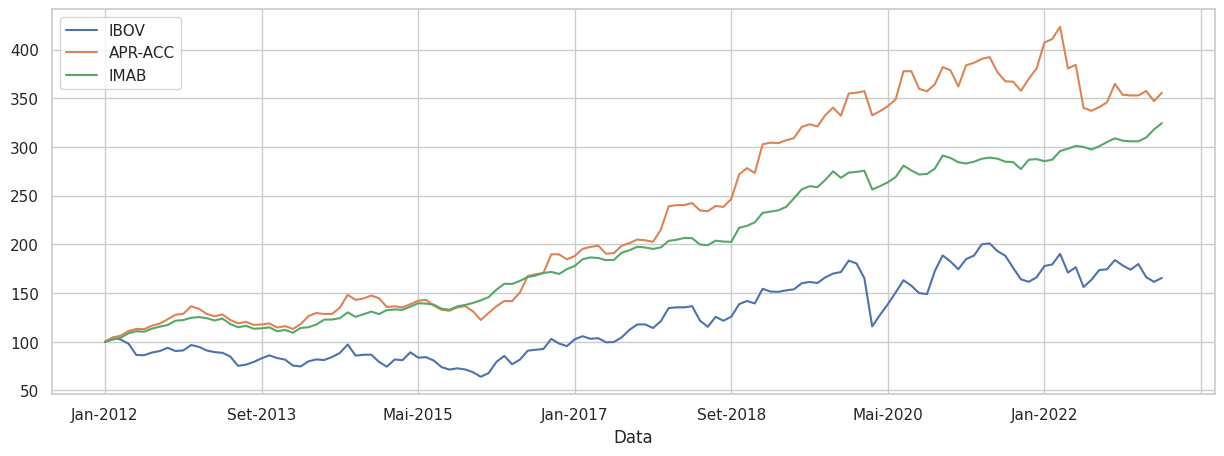

In [ ]:
# Gráfico de comparação IBOV x SELIC x Aprendizado
dados = dados*100 / dados.iloc[n_train]
dados[[ 'IBOV', 'APR-ACC','IMAB']].iloc[n_train:].plot(figsize = (15,5))

In [ ]:
# Retorno e volatilidade IMAB x IBOV x Aprendizado
ref_data = n_train
periodo = int(len(dados.index[ref_data+1:])/12)
print("Periodo:", dados.index[ref_data+1], "-", dados.index[-1], '(', periodo,')')

ret_acc = (dados[['IMAB', 'IBOV', 'APR-ACC']].iloc[-1]/dados[['IMAB', 'IBOV', 'APR-ACC']].iloc[ref_data])
print("Retorno acumulado:\n", ret_acc)
ret_aa = ((dados[['IMAB', 'IBOV', 'APR-ACC']].iloc[-1]/dados[['IMAB', 'IBOV', 'APR-ACC']].iloc[ref_data])**(1/periodo))-1
print("Retorno anualizado:\n", ret_aa)
vol_aa = dados_apr[['IMAB', 'IBOV', 'APR-CHG']].iloc[ref_data+1:].std()*np.sqrt(12)
print("Vol anualizada:\n", vol_aa)

Periodo: Fev-2012 - Abr-2023 ( 11 )
Retorno acumulado:
 IMAB       3.244955
IBOV       1.655753
APR-ACC    3.558097
dtype: float64
Retorno anualizado:
 IMAB       0.112945
IBOV       0.046908
APR-ACC    0.122305
dtype: float64
Vol anualizada:
 IMAB       0.073713
IBOV       0.221852
APR-CHG    0.134456
dtype: float64


In [ ]:
#Criando o data frame com informações para o algoritmo de aprendizado
dados_apr = dados_chg[['IBOV', 'SELIC-ACC']].copy()

#Selecionando o Momentum do IBOV para entrada do algoritmo
dados_apr['MOM1'] = dados_mom1['IBOV']
dados_apr['MOM3'] = dados_mom3['IBOV']
dados_apr['MOM6'] = dados_mom6['IBOV']

#Criando as colunas com os resultados de alocação ideais (saída do algoritmo)
dados_apr['IBOV-BUY'] = np.argmin(dados_apr[['IBOV', 'SELIC-ACC']].reset_index().drop(['Data'], axis=1).to_numpy(), axis=1)
dados_apr['SELIC-BUY'] = np.argmax(dados_apr[['IBOV', 'SELIC-ACC']].reset_index().drop(['Data'], axis=1).to_numpy(), axis=1)


In [ ]:
print(dados_apr)

              IBOV  SELIC-ACC      MOM1      MOM3      MOM6  IBOV-BUY  \
Data                                                                    
Set-2003  0.000000   0.000000  0.000000  0.000000  0.000000         0   
Out-2003  0.123173   0.016421  1.123173  0.000000  0.000000         1   
Nov-2003  0.122400   0.013435  1.122400  0.000000  0.000000         1   
Dez-2003  0.101719   0.013733  1.101719  1.388882  0.000000         1   
Jan-2004 -0.017314   0.012676  0.982686  1.215160  0.000000         0   
...            ...        ...       ...       ...       ...       ...   
Dez-2022 -0.024460   0.011233  0.975540  0.997254  1.113583         0   
Jan-2023  0.033681   0.011233  1.033681  0.977537  1.099509         1   
Fev-2023 -0.074923   0.009181  0.925077  0.932844  0.958082         0   
Mar-2023 -0.029064   0.011747  0.970936  0.928442  0.925892         0   
Abr-2023  0.025023   0.009181  1.025023  0.920666  0.899985         1   

          SELIC-BUY  
Data                 
Set-20